In [1]:
from functools import reduce
import scipy
from copy import deepcopy
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
from GRAPE import control_unitaries
from scipy.linalg import logm
import numpy as np


In [2]:
# Also if it's just the case that one control is as good as the rest,
# OR the convex solver doesn't resolve to enough tolerance, then the optimal control won't really do any better.

In [3]:
import dill 
"""
These pkl files contain PCA objects that define the Hamiltonian, 
the controls that were generated, the standard deviation of the controls
used in the robust optimization, etc
"""
pcas = ["pickled_controls228.pkl",
        "pickled_controls245.pkl",
        "pickled_controls261.pkl"
        "pickled_controls268.pkl",
        "pickled_controls271.pkl"]
# pca228 = dill.load(open(pcas[0], 'rb')) # SQRTY 
# pca245 = dill.load(open(pcas[1], 'rb')) # SQRTX
# pca261 = dill.load(open(pcas[2], 'rb')) # SQRT(ZZ)
choice = 3
num_keep = 200
pca = dill.load(open('../../../randomized_controls/' + pcas[choice], 'rb'))
pca.controlset = pca.controlset[:num_keep]
pca.controlset[0]

array([[ 0.018442  ,  0.22305981],
       [-0.09038149,  0.220071  ],
       [-0.06256052,  0.37293192],
       [ 0.02500528,  0.26837443],
       [ 0.10352559,  0.2537525 ],
       [ 0.01138708,  0.27368665]])

In [4]:
from scipy.misc import derivative
import numpy as np
from itertools import product

def error(combo, controls, target_operator, control_hamiltonians, ambient_hamiltonian0, dt):
    """Return the Hamiltonian that when exponentiated gives the error unitary from the target."""
    adjoint_target = np.conj(target_operator.T)
    newcontrols = deepcopy(controls)
    ambient_hamiltonian = [deepcopy(ah).astype("float") for ah in ambient_hamiltonian0]
    for cnum, value in enumerate(combo):
        cnum -= len(ambient_hamiltonian0)
        if cnum >= 0:
            newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
        if cnum < 0:
            assert cnum == -1, "For one qubit, there is only one amb. term we consider."
            idx = len(ambient_hamiltonian) - abs(cnum)
            ambient_hamiltonian[idx] *= float(value)
    controls = newcontrols
    # just check the first one
    assert np.isclose(ambient_hamiltonian[0], np.conj(ambient_hamiltonian[0].T)).all()
    for h in control_hamiltonians:
        assert np.isclose(h, np.conj(h.T)).all()
    step_unitaries = control_unitaries(ambient_hamiltonian,
                                       control_hamiltonians,
                                       newcontrols,
                                       dt)
    for u in step_unitaries:
        assert np.isclose(np.conj(u.T).dot(u), np.eye(2)).all(), np.conj(u.T).dot(u)
    unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
#     print("\nERROR UNITARY ----")
#     print(adjoint_target.dot(unitary))
#     print("ERROR UNITARY ----\n")
    error_gen = logm(adjoint_target.dot(unitary))
    entry = (error_gen[0, 0] - error_gen[1, 1])/2
    error_gen[0, 0] = entry
    error_gen[1, 1] = -entry    
    return -1.j * error_gen

def test_error():
    combo = (0, 0)
    controls = np.array([[1]])
    target_operator = np.array([[0, 1], [1, 0]])
    control_hamiltonians = [target_operator]
    ambient_hamiltonian0 = [np.eye(2)]
    dt = np.pi/2 + np.pi/2
    err = error(combo, controls, target_operator, control_hamiltonians, ambient_hamiltonian0, dt)
    err -= np.eye(err.shape[0])*err[0][0]
    
    err_uni = np.round(scipy.linalg.expm(-1.j*err), 4)
    assert np.isclose(err_uni[0, 0], err_uni[1, 1]) 
    assert np.isclose(err_uni[0, 1], err_uni[1, 0]) 
    assert np.isclose(scipy.linalg.norm(err_uni[0][1]), 1)
test_error()

In [5]:
def deg_deriv(controlset, target, control_hamiltonians, ambient_hamiltonian0, dt, deg):
    ds = []
    for control in controlset:
        d = compute_ith_derivative(lambda x:error(x,control, target, control_hamiltonians, ambient_hamiltonian0, dt) , np.array([0,0]), tuple(), deg, 4)
        ds.append(d)
    ds = np.array(ds)
#     shape = ds.shape
#     ds = ds.reshape(-1, 4)
#     for i in range(ds.shape[0]):
#         ds[i, :] = np.reshape(np.real(proj(ds[i,:].reshape(2,2))), (1,4))
#     ds = ds.reshape(*shape)
    return ds

def all_derivs(controlset, target, control_hamiltonians, ambient_hamiltonian0, dt, i):
    res = []
    for deg in range(i+1):
        ds = deg_deriv(controlset, target, control_hamiltonians, ambient_hamiltonian0, dt, deg)
        res.append(ds)
    return res

def partial(func, point, index, args):
    def f(x):
#         print("\nEVALUATING AT ----")
#         print([p if i!=index else x for i,p in enumerate(point)])
#         print("EVALUATING AT ----\n")
        return func([p if i!=index else x for i,p in enumerate(point)])
    return derivative(f, point[index], n=1, args=args,  dx=1.0/2**16)

def compute_partial(f, point, tup, args):
    """Compute the derivative of f at point of order tup, order must be positive. Tup tells you which derivatives to take
    i.e. 0,0,1 says take the derivative of the first element, then the first, then the second.
    args should be any accessory data to pass along."""
    if len(tup) == 1:
        return partial(f, point, tup[0], args)
    # I think this assumes everything is at 0
    return compute_partial(lambda x: partial(f, x, tup[0], args), point, tup[1:], args)  

def compute_ith_derivative(f, point, args, i, matsize):
    if i == 0:
        return np.array(f(point, *args)).flatten().reshape(1, -1)
    indices = list(range(len(point)))
    tups = product(*[indices]*i)
    res = np.zeros(tuple([len(point)]*i+[matsize]), dtype='complex')
    for tup in tups:
        res[tup] = compute_partial(f, point, tup, args).flatten()
    return res

In [6]:
example = lambda x: x[0]**2+x[1]**2 + x[0]*x[1] + x[0] + x[1] + 1
compute_partial(example, np.array([0, 0]), [1, 1], tuple())

2.0

In [7]:
compute_ith_derivative(example, np.array([0, 0]), tuple(), 0, 1)

array([[1]])

In [8]:
import numpy as np
u = np.array([[-0.66666667-0.66666667j, -0.33333333+0.66666667j],
 [-0.66666667+0.33333333j, -0.33333333-0.33333333j]])
(np.conj(u.T)).dot(u)

array([[ 1.44444446+0.j        , -0.11111112-0.33333334j],
       [-0.11111112+0.33333334j,  0.77777778+0.j        ]])

In [9]:
def test_all_derivs():
    combo = (0, 0)
    controls = np.array([[1]])
    target_operator = np.array([[0, 1], [1, 0]])
    control_hamiltonians = [target_operator]
    ambient_hamiltonian0 = [np.eye(2)]
    dt = np.pi/2
#     err = error(combo, controls, target_operator, control_hamiltonians, ambient_hamiltonian0, dt)
#     err -= np.eye(err.shape[0])*err[0][0]
    
#     err_uni = np.round(scipy.linalg.expm(-1.j*err), 4)
#     assert np.isclose(err_uni[0, 0], err_uni[1, 1]) 
#     assert np.isclose(err_uni[0, 1], err_uni[1, 0]) 
#     assert np.isclose(scipy.linalg.norm(err_uni[0][1]), 1)
    print(all_derivs(controlset=[controls], target=target_operator, control_hamiltonians=control_hamiltonians,
              ambient_hamiltonian0=ambient_hamiltonian0, dt=dt, i=1))
test_all_derivs()

[array([[[0.-0.j, 0.+0.j, 0.-0.j, 0.+0.j]]]), array([[[ 1.45519152e-11-4.54747351e-13j,
         -1.09139364e-11-1.75077730e-11j,
         -7.27595761e-12-1.67119651e-11j,
         -1.45519152e-11+4.54747351e-13j],
        [ 0.00000000e+00+9.69352280e-27j,
          5.14718540e+04-2.31921149e-11j,
          5.14718540e+04-2.31921149e-11j,
          0.00000000e+00-9.69352280e-27j]]])]


In [10]:
# It appears that requiring equality of higher degrees to zero is too hard/infeasible.

In [11]:
# from qutip import sigmax, sigmay, sigmaz
# import numpy as np
# ps = [np.eye(2), sigmax().data.toarray(), sigmay().data.toarray(), sigmaz().data.toarray()]
# ps = [p/np.sqrt(2) for p in ps]
# def hs(a, b):
#     return np.trace(np.conj(a.T).dot(b))
# for p in ps:
#     assert np.isclose(hs(p, p), 1)
# def proj(h):
#     return [np.real(hs(p, h)) for p in ps]

In [12]:
derivs = all_derivs(pca.controlset, pca.target_operator, pca.control_hamiltonians, pca.ambient_hamiltonian, pca.dt, 1)

In [13]:
tol = 1E-8

In [14]:
# import cvxpy as cp
# import numpy as np

# def optimal_weights(derivs, l=1):
#     scalar = 1
#     ham_consts = []
#     for deriv in derivs:
#         ham_consts.append(scalar * np.matrix([d.flatten() for d in deriv]).T)
#     omega = cp.Variable(len(derivs[0]))
#     constraints = [0 <= omega, omega <= 1, sum(omega)==1]
#     constraints += []
#     # For some reason, the results get better if we include the thing we're minimizing in the equality constraint.
#     # In addition, I think the equality isn't being enforced strictly enough.
# #     if len(ham_consts) != 1:
# #         equalities = ham_consts[:-1]
# #     else:
# #         equalities = ham_consts 
#     equalities = ham_consts[:-1]
#     for ham_const in equalities:
#         constraints += [np.real(ham_const)*omega == 0]
#         constraints += [np.imag(ham_const)*omega == 0]
#     objective = cp.Minimize(cp.norm(np.real(ham_consts[-1])*omega) + cp.norm(np.imag(ham_consts[-1])*omega))
#     prob = cp.Problem(objective, constraints)
#     result = prob.solve(abstol=tol, abstol_inacc=tol)
#     return omega.value

In [15]:
import cvxpy as cp
import numpy as np

def optimal_weights(derivs, l):
    mini = float('inf')
    for i in range(len(derivs[0])):
        ham_consts = []
        for deriv in derivs:
            ham_consts.append(np.matrix([d.flatten() for d in deriv]).T)
        omega = cp.Variable(len(derivs[0]))
        t = cp.Variable(1)
        constraints = [0 <= omega, omega <= 1, sum(omega)==1, t>=0]
        constraints += [omega[i] >= l*cp.inv_pos(t)]
        equalities = ham_consts[:-1]
        for ham_const in equalities:
            constraints += [np.real(ham_const)*omega == 0]
            constraints += [np.imag(ham_const)*omega == 0]
        objective = cp.Minimize(cp.norm(np.real(ham_consts[-1])*omega) + cp.norm(np.imag(ham_consts[-1])*omega) + t)
        prob = cp.Problem(objective, constraints)
        result = prob.solve(abstol=tol, abstol_inacc=tol)
        if result < mini and omega.value is not None:
            mini = result
            best_omega = omega
    return best_omega.value

In [16]:
x = np.array([np.array([[0, 1], [1, 0]])])

In [17]:
np.eye(2).dot(x.T)

array([[[0.],
        [1.]],

       [[1.],
        [0.]]])

In [18]:
x.T

array([[[0],
        [1]],

       [[1],
        [0]]])

In [19]:
x.dot(x.T)

array([[[[1],
         [0]],

        [[0],
         [1]]]])

In [20]:
np.tensordot(x, x.T, axes=1).shape

(1, 2, 2, 1)

In [21]:
import cvxpy as cp
import numpy as np

def optimal_weights_1st_order(derivs, l):
    mini = float('inf')
    for i in range(len(derivs[0])):
        ham_consts = []
        for deriv in derivs:
            ham_consts.append(np.matrix([d.flatten() for d in deriv]).T)
        omega = cp.Variable(len(derivs[0]))
        t = cp.Variable(1)
        constraints = [0 <= omega, omega <= 1, sum(omega)==1, t>=0]
        constraints += [omega[i] >= l*cp.inv_pos(t)]
        equalities = ham_consts[:-1]
        for ham_const in equalities:
            constraints += [np.real(ham_const)*omega == 0]
            constraints += [np.imag(ham_const)*omega == 0]
            
        hdh = [np.matmul(derivs[0][i].reshape(2, 2), d.reshape((2, 2, -1))) for i, d in enumerate(derivs[1])]
        hdh = [[a[:, :, 0], a[:, :, 1]] for a in hdh]

        dh = [d.reshape((2, 2, -1)) for d in derivs[1]]
        dh = [[a[:, :, 0], a[:, :, 1]] for a in dh]

        h = [d.reshape((2, 2, -1)) for d in derivs[0]]


        dhh = [[np.kron(h[i].T, el[0]), np.kron(h[i].T, el[1])] for i, el in enumerate(dh)]
        hdh = [[np.kron(np.eye(2), el[0]), np.kron(np.eye(2), el[1])] for i, el in enumerate(hdh)]
        dh = [[np.kron(np.eye(2), el[0]), np.kron(np.eye(2), el[1])] for el in dh]

        dhh = np.matrix(np.array(dhh).T.reshape(-1, len(derivs[0])))
        hdh = np.matrix(np.array(hdh).T.reshape(-1, len(derivs[0])))
        dh = np.matrix(np.array(dh).T.reshape(-1, len(derivs[0])))

        first_order = hdh + dhh + dh
        
        objective = cp.Minimize(cp.norm(np.real(first_order)*omega) + cp.norm(np.imag(first_order)*omega) + t)
        
        prob = cp.Problem(objective, constraints)
        result = prob.solve(abstol=tol, abstol_inacc=tol)
        if result < mini and omega.value is not None:
            mini = result
            best_omega = omega
    return best_omega.value

In [22]:
# import cvxpy as cp
# import numpy as np

# def optimal_weights_1st_order(derivs, l):
#     mini = float('inf')
#     for i in range(len(derivs[0])):
#         ham_consts = []
#         for deriv in derivs:
#             ham_consts.append(np.matrix([d.flatten() for d in deriv]).T)
#         omega = cp.Variable(len(derivs[0]))
#         t = cp.Variable(1)
#         constraints = [0 <= omega, omega <= 1, sum(omega)==1, t>=0]
#         constraints += [omega[i] >= l*cp.inv_pos(t)]
#         equalities = ham_consts[:-1]
#         for ham_const in equalities:
#             constraints += [np.real(ham_const)*omega == 0]
#             constraints += [np.imag(ham_const)*omega == 0]
            
            
#         hdh = [np.sum(np.matmul(derivs[0][i].reshape(2, 2), d.reshape((2, 2, -1))), axis=0) for i, d in enumerate(derivs[1])]
#         dh = [np.sum(d.reshape((2, 2, -1)), axis=0) for d in derivs[1]]
#         h = [d.reshape((2, 2, -1)) for d in derivs[0]]

#         dhh = [np.kron(h[i].T, el) for i, el in enumerate(hdh)]
#         hdh = [np.kron(np.eye(2), el) for el in hdh]
#         dh = [np.kron(np.eye(2), el) for el in dh]


#         first_order = np.matrix([(hdh[i] + dh[i] + dhh[i]).flatten() for i, _ in enumerate(dh)]).T
        
#         objective = cp.Minimize(cp.norm(np.real(first_order)*omega) + cp.norm(np.imag(first_order)*omega) + t)
        
#         prob = cp.Problem(objective, constraints)
#         result = prob.solve(abstol=tol, abstol_inacc=tol)
#         if result < mini and omega.value is not None:
#             mini = result
#             best_omega = omega
#     return best_omega.value

In [23]:
# import cvxpy as cp
# import numpy as np

# def optimal_weights(derivs, l):
#     ham_consts = []
#     for deriv in derivs:
#         ham_consts.append(np.matrix([d.flatten() for d in deriv]).T)
#     omega = cp.Variable(len(derivs[0]))
#     t = cp.Variable(1)
#     i = cp.Int()
#     constraints = [0 <= omega, omega <= 1, sum(omega)==1, t>=0]
#     constraints += [omega[i] >= l*cp.inv_pos(t)]
#     equalities = ham_consts[:-1]
#     for ham_const in equalities:
#         constraints += [np.real(ham_const)*omega == 0]
#         constraints += [np.imag(ham_const)*omega == 0]
#     objective = cp.Minimize(cp.norm(np.real(ham_consts[-1])*omega) + cp.norm(np.imag(ham_consts[-1])*omega) + t)
#     prob = cp.Problem(objective, constraints)
#     result = prob.solve(abstol=tol, abstol_inacc=tol)
#     return best_omega.value

In [24]:
def hist_and_support(weights, num=10):
    plt.hist(weights)
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx

# Plotting Utils

In [25]:
%matplotlib inline 
def oned_off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt
    %matplotlib inline 


    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = list(zip(values, [0 for _ in values]))
    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure
    
    for i, row in enumerate(projs[:-1, :]):
        plt.plot(range(len(row)), row)
    plt.plot(range(len(projs[-1, :])), projs[-1, :], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.axvline((num_points-1)/2)
    plt.subplot(212)  # the second subplot in the first figure
    
    for i, row in enumerate(fidelities[:-1, :]):
        plt.plot(range(len(row)), -np.log(1 - row))
    plt.plot(range(len(fidelities[-1, :])), -np.log(1 - fidelities[-1, :]), label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()

def off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt

    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = itertools.product(*values_to_plot)
    new_combinations = []
    for combo in combinations:
        new_combo = []
        for index in corr:
            new_combo.append(combo[index])
        new_combinations.append(new_combo)
    combinations = new_combinations

    tuple_length = len(combinations[0])
    standard_ordering = list(range(tuple_length))
    ordering = standard_ordering
    indices = generate_indices(len(values), ordering)

    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure

    for i, row in enumerate(projs[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), reordered_row)
    plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.subplot(212)  # the second subplot in the first figure
    for i, row in enumerate(fidelities[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), -np.log(1 - reordered_row))
    plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()
    
def off_diagonals2(pca1, pca2, scale):
    for pca in [pca1, pca2]:
        import itertools
        from itertools import product
        import multiprocessing
        from pauli_channel_approximation import compute_dpn_and_fid
        import matplotlib.pyplot as plt
        
        def generate_indices(num_points, order_desired):
            num_indices = len(order_desired)
            tuples = product(range(num_points), repeat=num_indices)
            indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
            return indices

        values_to_plot = []
        corr = []
        for i, detuning in enumerate(pca.detunings):
            # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
            values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
            values_to_plot.append(values)
            corr.append(i)
        # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
        combinations = itertools.product(*values_to_plot)
        new_combinations = []
        for combo in combinations:
            new_combo = []
            for index in corr:
                new_combo.append(combo[index])
            new_combinations.append(new_combo)
        combinations = new_combinations

        tuple_length = len(combinations[0])
        standard_ordering = list(range(tuple_length))
        ordering = standard_ordering
        indices = generate_indices(len(values), ordering)

        # Multiprocessing for faster evaluation.
        pool = multiprocessing.Pool(num_processors)
        lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs)
               for combo in combinations]
        projs_fidelities = pool.map(compute_dpn_and_fid, lst)
        pool.close()

        # Compute the off diagonals and fidelities.
        projs = [pf[0] for pf in projs_fidelities]
        fidelities = [pf[1] for pf in projs_fidelities]
        projs = np.vstack(projs).T
        fidelities = np.vstack(fidelities).T
        # If you just uncomment the first two rows it fails for some reason...
#         for i, row in enumerate(projs[:-1, :]):
#             reordered_row = np.array([row[j] for j in indices])
#             plt.plot(range(len(row)), reordered_row)
        plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], c='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()


In [26]:
# Careful to set t to be positive

In [27]:
num_points = 11
num_processors = 4
param = 1E-3
num_weights = 8
scale = .01

In [28]:
weights1 = optimal_weights_1st_order(derivs, l=0)

2.051819412685053e-13
[[-1.01469188e-14+5.99387464e-17j]
 [-1.22495083e-13+7.64514430e-14j]
 [-1.23098333e-13-7.67504659e-14j]
 [ 1.01469188e-14-5.99387464e-17j]]
0.03493009049944785
SUPPORT:0.9999999990262137
NUM CONTROLS: 8


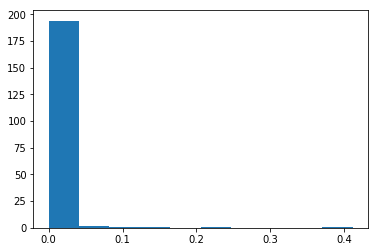

In [29]:
import matplotlib.pyplot as plt
zeroth = np.matrix([d.flatten() for d in derivs[0]]).T
oneth = np.matrix([d.flatten() for d in derivs[1]]).T
print(scipy.linalg.norm(zeroth.dot(weights1)))
print(zeroth.dot(weights1))
print(scipy.linalg.norm(oneth.dot(weights1)))
indices = hist_and_support(weights1, num_weights)

In [54]:
# Putting in the ambient hamiltonian wrong fails silently and messes everything up.

DOING COMBO [-0.08, 0.0]
DOING COMBO [-0.1, -0.1]
DOING COMBO [-0.060000000000000005, -0.060000000000000005]
DOING COMBO [-0.1, 0.06]
DOING COMBO [-0.060000000000000005, -0.04000000000000001]
DOING COMBO [-0.1, 0.07999999999999999]
DOING COMBO [-0.08, 0.01999999999999999]
DOING COMBO [-0.1, -0.08]
DOING COMBO [-0.060000000000000005, -0.020000000000000004]
DOING COMBO [-0.1, 0.1]
DOING COMBO [-0.060000000000000005, 0.0]
DOING COMBO [-0.08, 0.04000000000000001]
DOING COMBO [-0.1, -0.060000000000000005]
DOING COMBO [-0.08, -0.1]
DOING COMBO [-0.060000000000000005, 0.01999999999999999]
DOING COMBO [-0.08, -0.08]
DOING COMBO [-0.1, -0.04000000000000001]
DOING COMBO [-0.08, 0.06]
DOING COMBO [-0.060000000000000005, 0.04000000000000001]
DOING COMBO [-0.08, -0.060000000000000005]
DOING COMBO [-0.060000000000000005, 0.06]
DOING COMBO [-0.1, -0.020000000000000004]
DOING COMBO [-0.08, 0.07999999999999999]
DOING COMBO [-0.08, -0.04000000000000001]
DOING COMBO [-0.08, 0.1]
DOING COMBO [-0.1, 0.0]
D

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


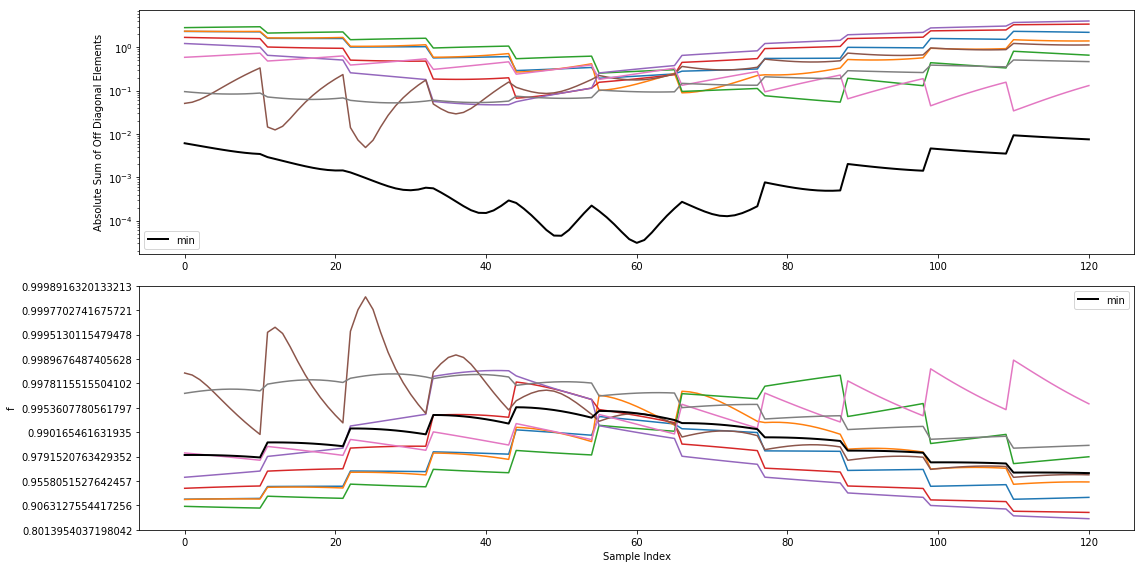

In [31]:
pca1 = dill.load(open('../../../randomized_controls/' + pcas[choice], 'rb'))
subweights = weights1[indices]
pca1.controlset = [pca1.controlset[i] for i in indices]
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca1, scale)


In [33]:
weights0 = optimal_weights(derivs[:1], l=param*10)

1.4609500036475507e-13
[[-3.19400252e-15+8.07675553e-17j]
 [-1.03002177e-13-2.74001064e-15j]
 [-1.03444315e-13+2.37701976e-15j]
 [ 3.19400252e-15-8.07675553e-17j]]
4.009841330441
SUPPORT:0.9999999993156279
NUM CONTROLS: 8


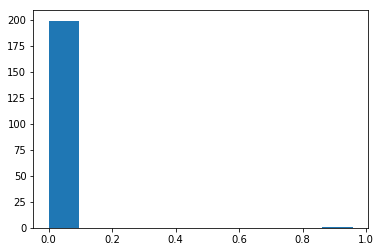

In [34]:
import matplotlib.pyplot as plt
zeroth = np.matrix([d.flatten() for d in derivs[0]]).T
oneth = np.matrix([d.flatten() for d in derivs[1]]).T
print(scipy.linalg.norm(zeroth.dot(weights0)))
print(zeroth.dot(weights0))
print(scipy.linalg.norm(oneth.dot(weights0)))
indices = hist_and_support(weights0, num_weights)

DOING COMBO [-0.1, -0.1]
DOING COMBO [-0.1, 0.06]
DOING COMBO [-0.08, 0.0]
DOING COMBO [-0.060000000000000005, -0.060000000000000005]
DOING COMBO [-0.1, -0.08]
DOING COMBO [-0.060000000000000005, -0.04000000000000001]
DOING COMBO [-0.08, 0.01999999999999999]
DOING COMBO [-0.1, 0.07999999999999999]
DOING COMBO [-0.1, -0.060000000000000005]
DOING COMBO [-0.060000000000000005, -0.020000000000000004]
DOING COMBO [-0.1, -0.04000000000000001]
DOING COMBO [-0.08, 0.04000000000000001]
DOING COMBO [-0.1, -0.020000000000000004]
DOING COMBO [-0.060000000000000005, 0.0]
DOING COMBO [-0.1, 0.1]
DOING COMBO [-0.08, 0.06]
DOING COMBO [-0.1, 0.0]
DOING COMBO [-0.08, 0.07999999999999999]
DOING COMBO [-0.060000000000000005, 0.01999999999999999]
DOING COMBO [-0.08, -0.1]
DOING COMBO [-0.1, 0.01999999999999999]
DOING COMBO [-0.08, 0.1]
DOING COMBO [-0.060000000000000005, 0.04000000000000001]
DOING COMBO [-0.08, -0.08]
DOING COMBO [-0.060000000000000005, -0.1]
DOING COMBO [-0.1, 0.04000000000000001]
DOING 

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


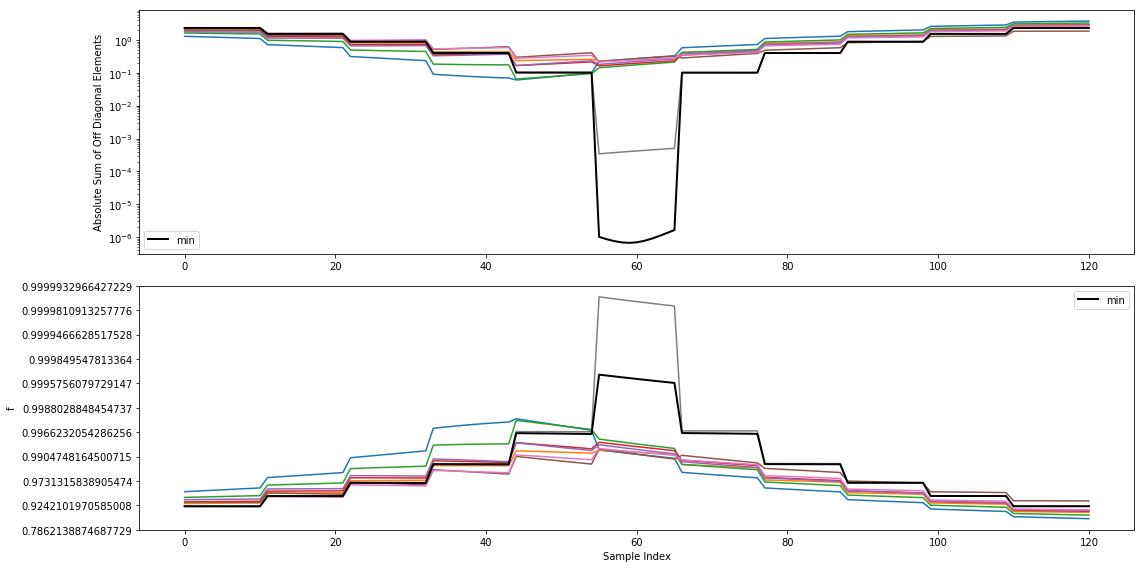

In [35]:
pca0 = dill.load(open('../../../randomized_controls/' + pcas[choice], 'rb'))
subweights = weights0[indices]
pca0.controlset = [pca0.controlset[i] for i in indices]
pca0.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca0, scale)

DOING COMBO [-0.0008, 0.0]
DOING COMBO [-0.0006000000000000001, -0.0006000000000000001]
DOING COMBO [-0.001, -0.001]
DOING COMBO [-0.001, 0.0006000000000000001]
DOING COMBO [-0.0008, 0.0002000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00039999999999999996]
DOING COMBO [-0.001, -0.0008]
DOING COMBO [-0.001, 0.0008000000000000001]
DOING COMBO [-0.0008, 0.00039999999999999996]
DOING COMBO [-0.001, -0.0006000000000000001]
DOING COMBO [-0.0006000000000000001, -0.00019999999999999998]
DOING COMBO [-0.001, 0.001]
DOING COMBO [-0.0008, 0.0006000000000000001]
DOING COMBO [-0.001, -0.00039999999999999996]
DOING COMBO [-0.0006000000000000001, 0.0]
DOING COMBO [-0.001, -0.00019999999999999998]
DOING COMBO [-0.0008, -0.001]
DOING COMBO [-0.0008, 0.0008000000000000001]
DOING COMBO [-0.001, 0.0]
DOING COMBO [-0.0006000000000000001, 0.0002000000000000001]
DOING COMBO [-0.0008, -0.0008]
DOING COMBO [-0.0008, 0.001]
DOING COMBO [-0.001, 0.0002000000000000001]
DOING COMBO [-0.00060000000000000

DOING COMBO [-0.00019999999999999998, -0.001]
DOING COMBO [-0.00019999999999999998, 0.0006000000000000001]
DOING COMBO [-0.00039999999999999996, 0.0]
DOING COMBO [0.0, -0.00019999999999999998]
DOING COMBO [-0.00019999999999999998, -0.0008]
DOING COMBO [-0.00019999999999999998, 0.0008000000000000001]
DOING COMBO [-0.00039999999999999996, 0.0002000000000000001]
DOING COMBO [0.0, 0.0]
DOING COMBO [-0.00019999999999999998, 0.001]
DOING COMBO [-0.00019999999999999998, -0.0006000000000000001]
DOING COMBO [0.0, -0.001]
DOING COMBO [0.0, 0.0008000000000000001]
DOING COMBO [-0.00019999999999999998, -0.00039999999999999996]
DOING COMBO [0.0, 0.0002000000000000001]
DOING COMBO [0.0002000000000000001, 0.0002000000000000001]
DOING COMBO [0.0, 0.001]
DOING COMBO [0.00039999999999999996, -0.00039999999999999996]
DOING COMBO [0.0, 0.00039999999999999996]
DOING COMBO [0.0002000000000000001, 0.00039999999999999996]
DOING COMBO [0.0002000000000000001, -0.001]
DOING COMBO [0.00039999999999999996, -0.00019

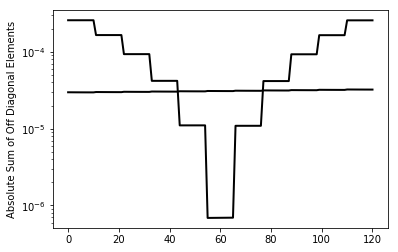

In [40]:
off_diagonals2(pca1, pca0, 1)

array([[ 0.018442  ,  0.22305981],
       [-0.09038149,  0.220071  ],
       [-0.06256052,  0.37293192],
       [ 0.02500528,  0.26837443],
       [ 0.10352559,  0.2537525 ],
       [ 0.01138708,  0.27368665]])